In [2]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..', 'config'), 'db_default_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()


import RecallAdjuster as ra
from importlib import reload

import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime.strptime('2018-04-01', '%Y-%m-%d')
date_pairs = []
for x in range(9,-1,-1):
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x)).strftime('%Y-%m-%d')
        )
    )

import seaborn as sns

In [6]:
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[500],
        entity_demos='joco',
        #entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way'
)

In [7]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_test.model_adjustment_results_race_3way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_w_to_b AS recall_w_to_b,
       r.base_recall_w_to_h AS recall_w_to_h,
       r.base_recall_b_to_h AS recall_b_to_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""

ts_df = pd.read_sql(sql, conn)

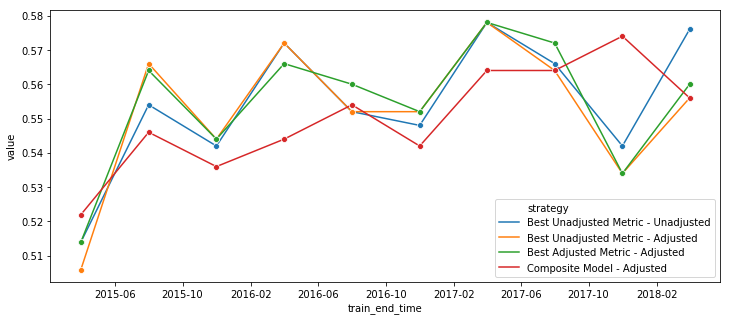

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

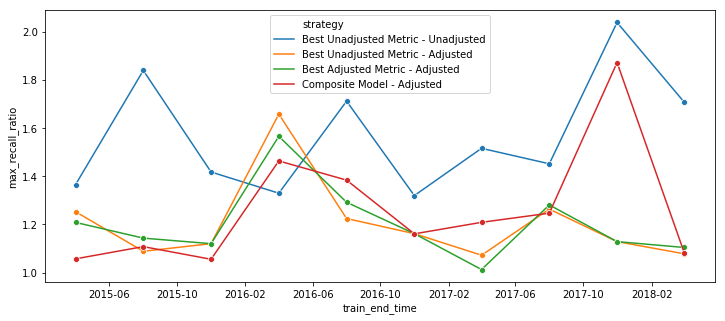

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)

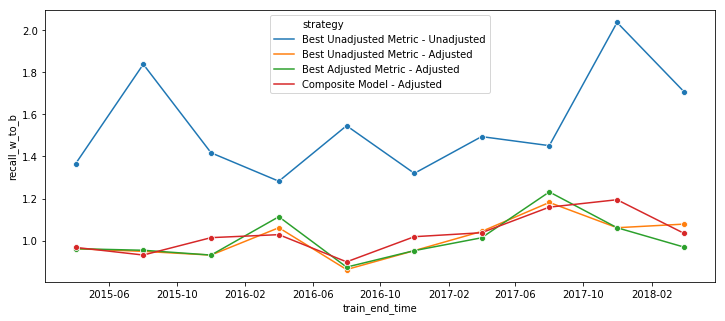

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

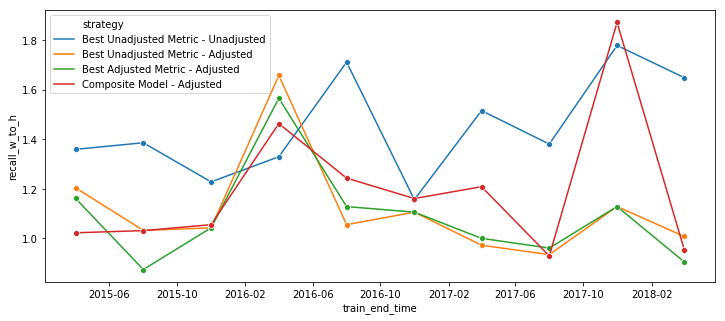

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

In [12]:
ts_df.groupby(['strategy']).describe()

list_size                            \
                                        count   mean  std    min    25%   
strategy                                                                  
Best Adjusted Metric - Adjusted          10.0  500.0  0.0  500.0  500.0   
Best Unadjusted Metric - Adjusted        10.0  500.0  0.0  500.0  500.0   
Best Unadjusted Metric - Unadjusted      10.0  500.0  0.0  500.0  500.0   
Composite Model - Adjusted               10.0  500.0  0.0  500.0  500.0   

                                                         max_recall_ratio  \
                                       50%    75%    max            count   
strategy                                                                    
Best Adjusted Metric - Adjusted      500.0  500.0  500.0             10.0   
Best Unadjusted Metric - Adjusted    500.0  500.0  500.0             10.0   
Best Unadjusted Metric - Unadjusted  500.0  500.0  500.0             10.0   
Composite Model - Adjusted           500.0  500.0  500.0             10.0   

                                                                             \
                                         mean       std       min       25%   
strategy                                                                      
Best Adjusted Metric - Adjusted      1.201942  0.152353  1.013057  1.122466   
Best Unadjusted Metric - Adjusted    1.204964  0.174185  1.072437  1.096690   
Best Unadjusted Metric - Unadjusted  1.569565  0.243270  1.319834  1.378335   
Composite Model - Adjusted           1.263992  0.254017  1.055597  1.088985   

                                                                   \
                                          50%       75%       max   
strategy                                                            
Best Adjusted Metric - Adjusted      1.152654  1.262900  1.565657   
Best Unadjusted Metric - Adjusted    1.145405  1.245814  1.657754   
Best Unadjusted Metric - Unadjusted  1.483783  1.710427  2.038014   
Composite Model - Adjusted           1.185011  1.349750  1.871681   

                                    recall_b_to_h                      \
                                            count      mean       std   
strategy                                                                
Best Adjusted Metric - Adjusted              10.0  1.087315  0.189089   
Best Unadjusted Metric - Adjusted            10.0  1.113365  0.212743   
Best Unadjusted Metric - Unadjusted          10.0  0.944037  0.102801   
Composite Model - Adjusted                   10.0  1.161323  0.235054   

                                                                             \
                                          min       25%       50%       75%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.780621  0.948010  1.092156  1.196859   
Best Unadjusted Metric - Adjusted    0.791315  0.967113  1.104568  1.208962   
Best Unadjusted Metric - Unadjusted  0.753750  0.873698  0.958617  1.009615   
Composite Model - Adjusted           0.802008  1.045292  1.124185  1.329425   

                                              recall_w_to_b            \
                                          max         count      mean   
strategy                                                                
Best Adjusted Metric - Adjusted      1.406250          10.0  1.005850   
Best Unadjusted Metric - Adjusted    1.562500          10.0  1.007903   
Best Unadjusted Metric - Unadjusted  1.106716          10.0  1.546203   
Composite Model - Adjusted           1.567248          10.0  1.028115   

                                                                             \
                                          std       min       25%       50%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.104150  0.873549  0.952432  0.964856   
Best Unadjusted Metric - Adjusted    0

### Sensitivity to overall list size

In [18]:
conn.dispose()
conn = connect()
reload(ra)

<module 'RecallAdjuster' from '/Users/kit/Documents/code/johnson-county-ddj/data_exploration/kit_bias_testbed/RecallAdjuster.py'>

In [19]:
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[100, 200, 300, 400, 500, 750, 1000],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way'
)

In [28]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_test.model_adjustment_results_race_3way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_w_to_b AS recall_w_to_b,
       r.base_recall_w_to_h AS recall_w_to_h,
       r.base_recall_b_to_h AS recall_b_to_h,
       r.base_frac_w AS frac_w,
       r.base_frac_b AS frac_b,
       r.base_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""

ts_df = pd.read_sql(sql, conn)

In [29]:
ts_df.head()

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_w_to_b,recall_w_to_h,recall_b_to_h,frac_w,frac_b,frac_h
0,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,300,precision@,300_abs,0.513333,1.424176,1.424176,1.372544,0.963746,0.726667,0.206667,0.066667
1,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,750,precision@,750_abs,0.497333,1.300222,1.300222,1.294853,0.995871,0.700000,0.224000,0.076000
2,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,100,precision@,100_abs,0.580000,1.476132,1.148746,1.476132,1.284995,0.740000,0.210000,0.050000
3,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,1000,precision@,1000_abs,0.490000,1.376635,1.376635,1.293558,0.939653,0.713000,0.215000,0.072000
4,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,400,precision@,400_abs,0.505000,1.398441,1.255714,1.398441,1.113662,0.717500,0.215000,0.067500


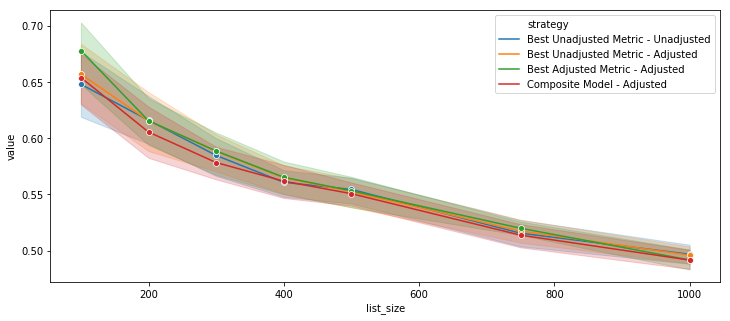

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)

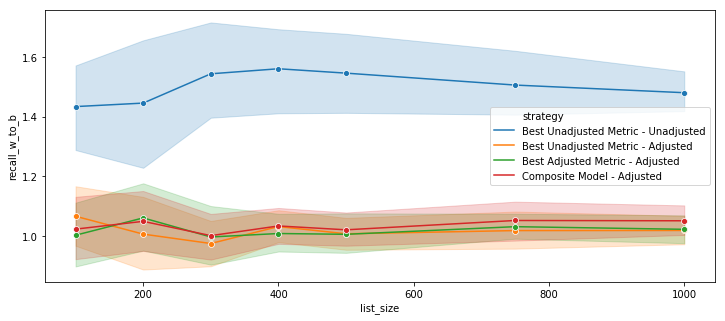

In [25]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

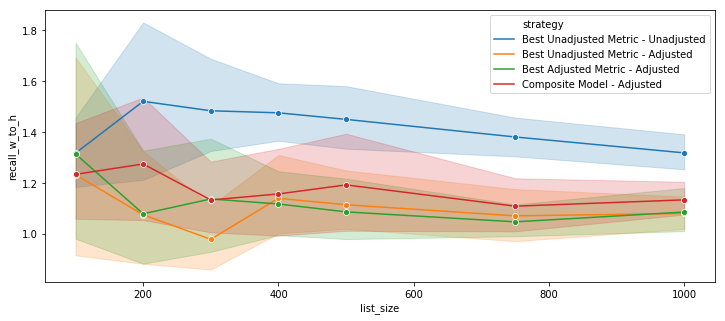

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

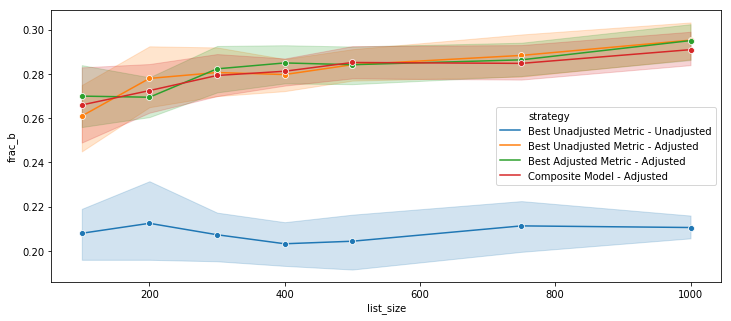

In [31]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_b', hue='strategy', marker="o", ax=ax)

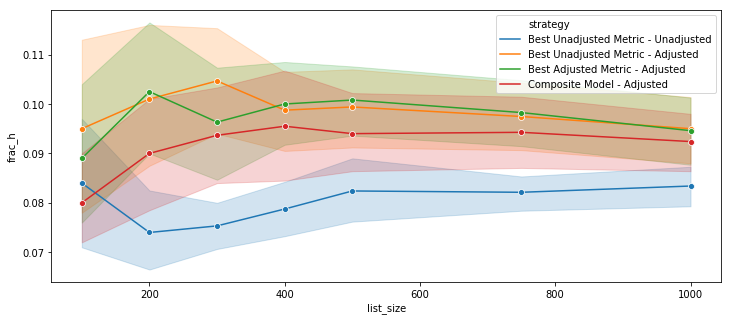

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_h', hue='strategy', marker="o", ax=ax)

Our process of equalizing recall actually corresponds pretty well to Hardt's concept of `equal opportunity` (https://arxiv.org/pdf/1610.02413.pdf). Where that paper seeks to find a optimal point across the entire score, we instead consider the case where we're subject to the constrain of a specific overall size, common in many programmatic applications with limited resources/budgets. Aside from that, the process/definitions are similar enough there isn't much of a real comparison to be made.


Dwork's decoupled classifiers bear some resemblence to the composite classifier considered here, but classifiers are trained independently for each group then combined with a joint loss function that reflects the balances between overall accuracy and fairness metrics (with a monotonicity requirement on this joint loss). This would suggest the following procedure:
- Run a grid of models trained separately on each group
- Calculate precision@k for k={1,2,3,...,N} for each group-specific classifier
- For each value of k, choose a best model for each group (tie breaking??) based on precision
- Restricting to combinations across groups that sum to a desired total size (e.g. top 500 or 1000), calculate a joint loss for each combination that balances recall equity and overall precision
- Choose the set of classifiers with lowest joint loss at the desired size
- Evaluate performance on the next time period forward

Here we'll need to figure out the appropriate form of the joint loss function, particularly for balancing recall across multiple groups and probably test across multiple weighting parameters. In practice, can likely restrict the search space somewhat by focusing on reasonable sets (those with too few of any one group will have too low recall). As a first step, might be worth considering taking this approach through the set of models by group-k then simply balancing on recall as we've been doing above (w/o the formal joint loss function) --- this would more directly assess the precision trade-off at the best possible level of equity from decoupled classifiers (better precision might be possible with the joint loss calculation, but at the expense of sacrificing a degree of equity).

http://proceedings.mlr.press/v81/dwork18a/dwork18a.pdf
https://www.youtube.com/watch?v=OR0kn40M_Z0


#### Re-running after a bit of refactoring...

In [39]:
conn.dispose()
conn = connect()
reload(ra)

<module 'RecallAdjuster' from '/Users/kit/Documents/code/johnson-county-ddj/data_exploration/kit_bias_testbed/RecallAdjuster.py'>

In [40]:
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[500],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way'
)

In [43]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_test.model_adjustment_results_race_3way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_w_to_b AS recall_w_to_b,
       r.base_recall_w_to_h AS recall_w_to_h,
       r.base_recall_b_to_h AS recall_b_to_h,
       r.base_frac_w AS frac_w,
       r.base_frac_b AS frac_b,
       r.base_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE train_end_time > past_train_end_time
;
"""

ts_df2 = pd.read_sql(sql, conn)

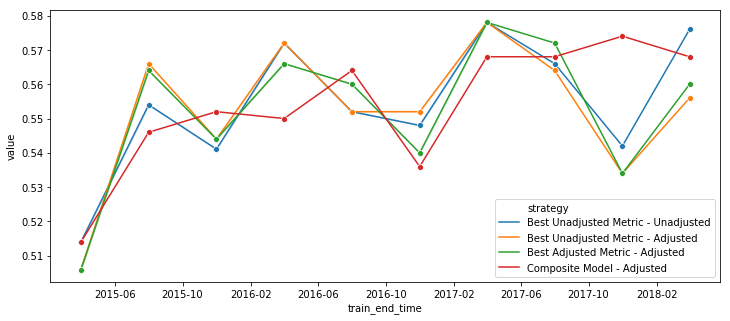

In [45]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df2, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

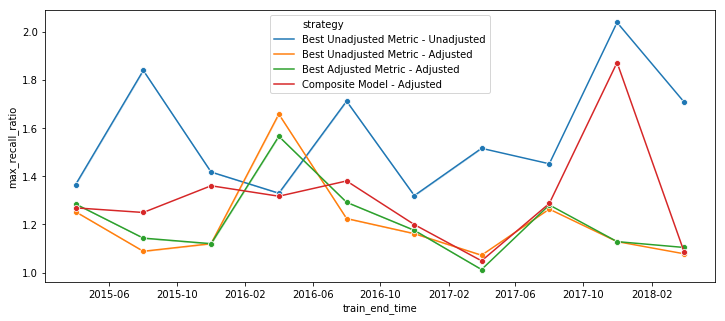

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df2, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)

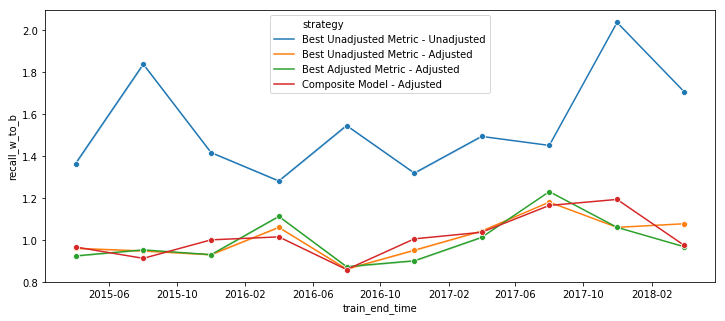

In [47]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df2, x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

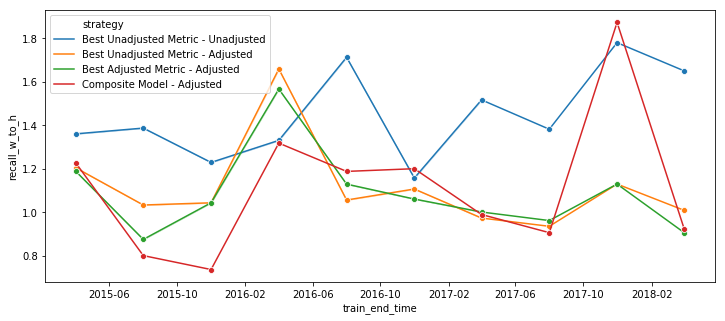

In [59]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df2, x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

#### Switching to Dwork-"Light" method for composite
That is, identify the highest-precision model at every cut-off and use the one for each group that corresponds to the determined group sizes determined in the previous train_end_time. This is definitely a more principaled approach than our existing one of guessing a "reasonable" set of thresholds for choosing the models, so we'll switch to this generally.

Dwork would further suggest fully decoupling the models (including training on each group separately), but we'll need to run additional experiments to look at this.

In [53]:
conn.dispose()
conn = connect()
reload(ra)

myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[500],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way'
)

In [54]:
ts_df3 = pd.read_sql(sql, conn)

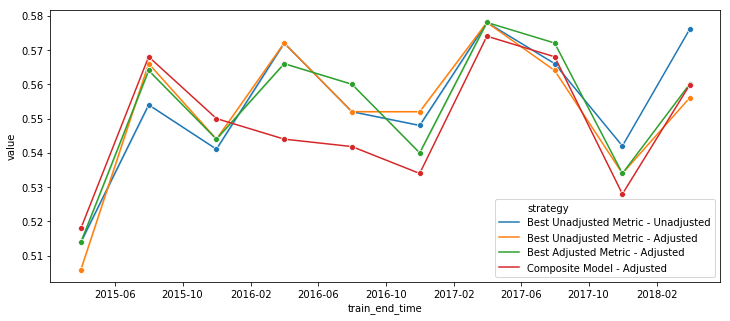

In [55]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

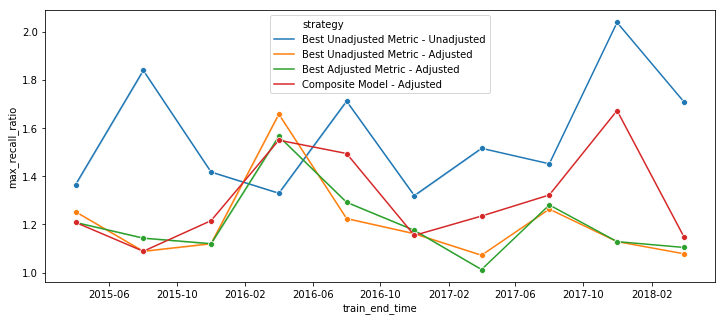

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)

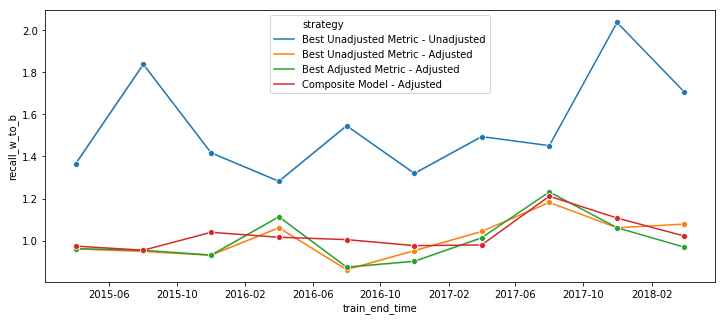

In [57]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

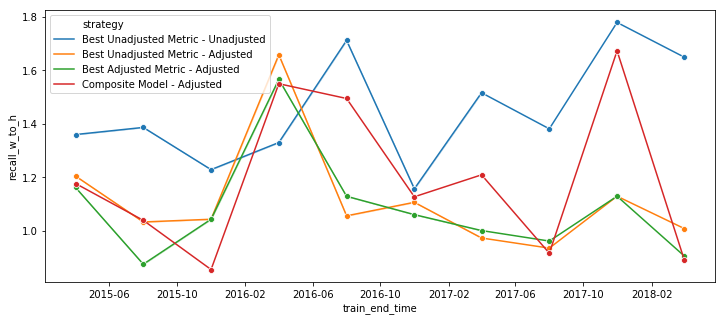

In [58]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

Overall, this doesn't seem appreciably different than the composite we were using, especially given the noise in the hispanic data, but that's probably more an indication either that the guess I was making (or underlying assumping of similar precisions) was close enough or that the models perform similarly enough for this variation not to matter. Either way, a grid including fully decoupled models seems worth a shot, but I'd be surprised if it cleans this up very appreciably.

In [60]:
# repeat list size experiment with new composite logic
conn.dispose()
conn = connect()
reload(ra)

myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[100, 200, 300, 400, 500, 750, 1000],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way'
)

In [61]:
ts_df = pd.read_sql(sql, conn)

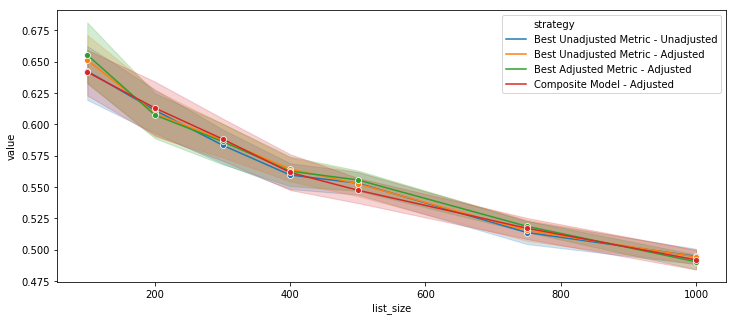

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)

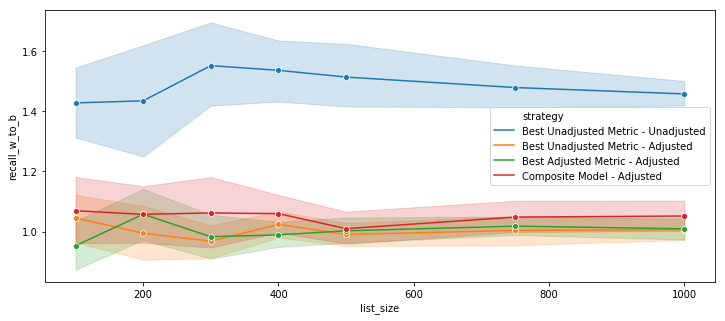

In [63]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

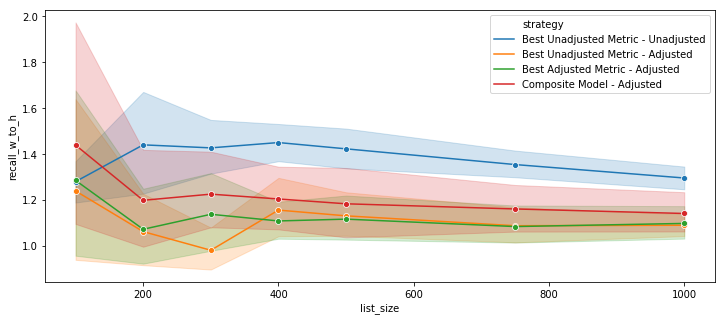

In [64]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

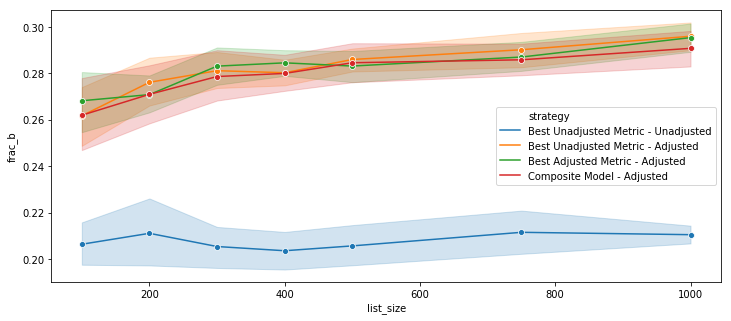

In [65]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_b', hue='strategy', marker="o", ax=ax)

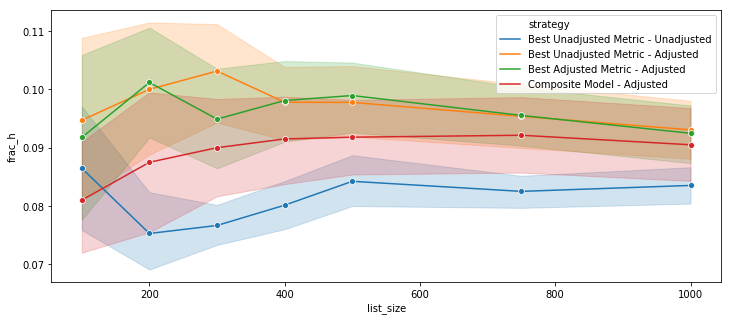

In [66]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_h', hue='strategy', marker="o", ax=ax)

Pretty similar in general to the original composite logic. In both, it really seems as though the composite version isn't doing so well at including as many hispanics or as well at equalizing their recall, even as the lists get larger. One reasonable hypothesis for this might be that because there are fewer hispanics, there is much more noise in their predictions such that picking out the best model, we often end up picking a more noisy one that underperforms in the future compared to choosing a model that performs well overall is more stable and ends up performing better on the small group. Perhaps the fully decoupled models will perform better, but it certainly seems possible they'll be subject to the same issue. Will also be interesting to try a bootstrapping approach to see if things look cleaner if we readjust the relative sizes of the group (though I have some worries about how that works with basically having more identical points).

### Fully Decoupled...

Ran a set of fully decoupled random forests (that is, training separate models for each group) with overall list size k=500 to explore the effects of this added flexibility. These decoupled models were combined with the models trained on the full set (sort of either extreme of the transfer learning Dwork describes) allowing the final composite result to choose the best-performing model for each subgroup, decoupled or not.

In [68]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_test.model_adjustment_results_race_3way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_w_to_b AS recall_w_to_b,
       r.base_recall_w_to_h AS recall_w_to_h,
       r.base_recall_b_to_h AS recall_b_to_h,
       r.base_frac_w AS frac_w,
       r.base_frac_b AS frac_b,
       r.base_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
      AND r.list_size = {list_size}

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
    AND r.list_size = {list_size}

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
    AND r.list_size = {list_size}

UNION ALL

-- Composite model (no decoupled models)
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE train_end_time > past_train_end_time
    AND list_size = {list_size}

UNION ALL

-- Composite model (with decoupled models)
SELECT 'Composite w/ Decoupled - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way_decoupled
WHERE train_end_time > past_train_end_time
    AND list_size = {list_size}
;
""".format(list_size=500)


In [69]:
ts_df3 = pd.read_sql(sql, conn)

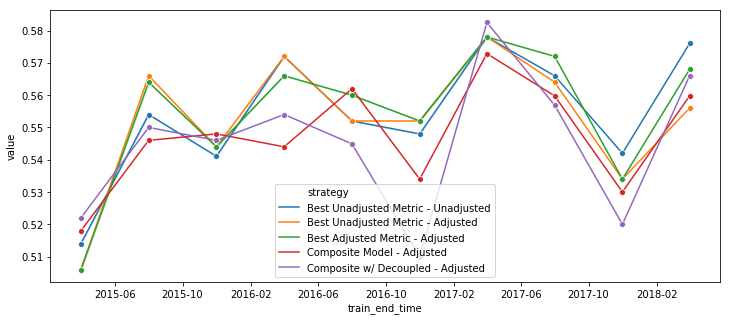

In [70]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

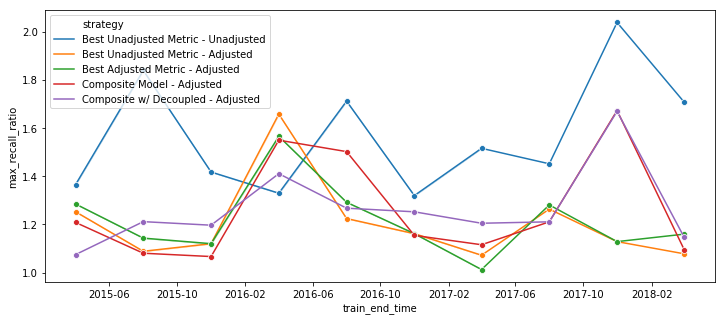

In [71]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)

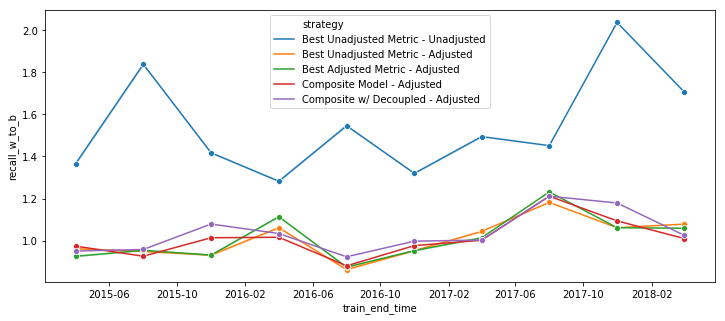

In [72]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

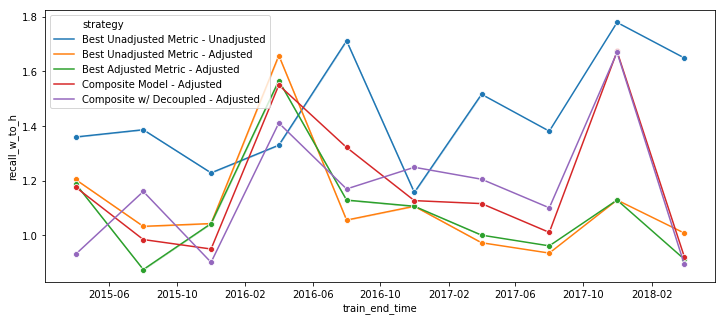

In [73]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

Overall, results for the composite models aren't looking too promisng, with or without decoupling. It seems worth adding the relevant logic into the `RecallAdjuster` code both for completeness and to allow for the possibility that this strategy will work better on other data sets, but at least here and especially for the relatively small group (in this case, Hispanic individuals), it seems as though this extra bit of freedom has a tendancy towards overfitting leading to underperformance when generalizing to future data.

In [94]:
# repeat list size experiment with new composite logic
conn.dispose()
conn = connect()
reload(ra)

myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[100, 200, 300, 400, 500, 750, 1000],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way',
        decoupled_experiments=[('b874f45daaaa6c66bf9895d7d86454ca', 'B'), ('bc49ccb1038354442c6863ed65f10827', 'H'), ('53bf2da23d0ee19c0078af3b007f5e96', 'W')],
        decoupled_entity_demos='kit_bias_class_test.currmatch_entity_demos'
)

In [95]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_test.model_adjustment_results_race_3way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_w_to_b AS recall_w_to_b,
       r.base_recall_w_to_h AS recall_w_to_h,
       r.base_recall_b_to_h AS recall_b_to_h,
       r.base_frac_w AS frac_w,
       r.base_frac_b AS frac_b,
       r.base_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model (no decoupled models)
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE train_end_time > past_train_end_time

UNION ALL

-- Composite model (with decoupled models)
SELECT 'Composite w/ Decoupled - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_decoupled_race_3way
WHERE train_end_time > past_train_end_time
;
"""

In [96]:
ts_df = pd.read_sql(sql, conn)

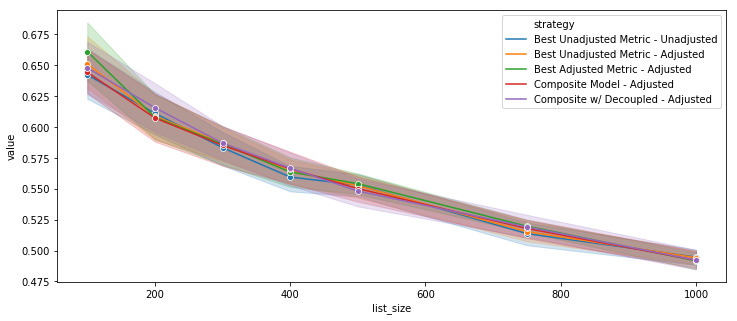

In [97]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)

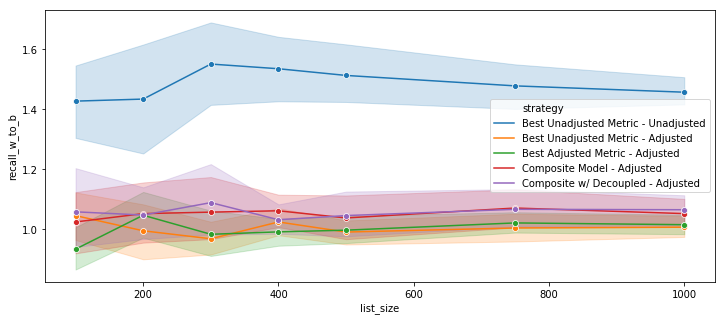

In [98]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

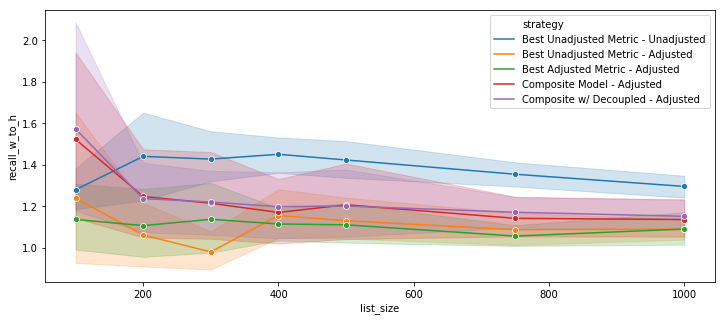

In [99]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

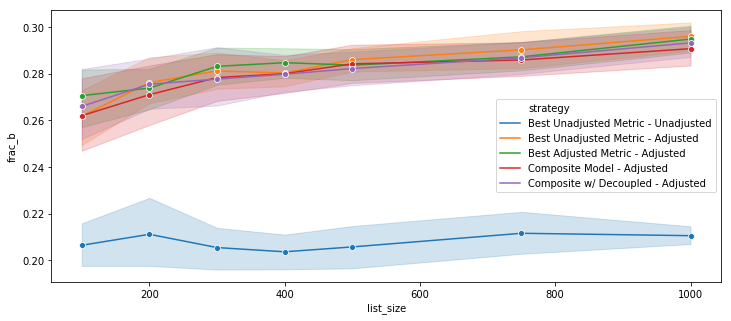

In [100]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_b', hue='strategy', marker="o", ax=ax)

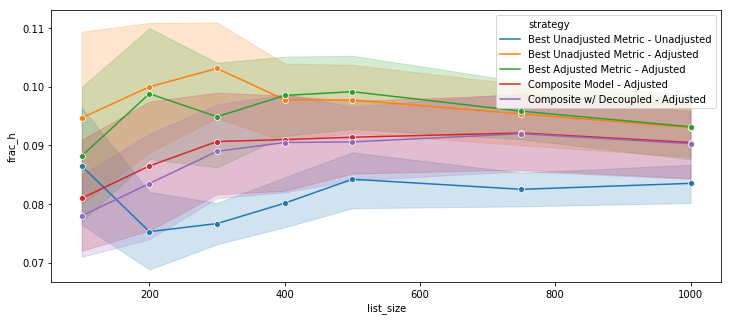

In [101]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_h', hue='strategy', marker="o", ax=ax)

In [105]:
# pickle a few things for future use / figure creation

import pickle

myRA.engine.close()
myRA.engine = None

export_dict = {
    'recall_adjuster_obj': myRA,
    'time_series_plot_df': ts_df3,
    'list_size_plot_df': ts_df
}

pickle.dump(export_dict, open('joco_recall_adj_data.pkl', 'wb'))

In [106]:
del(export_dict)

In [108]:
conn = connect()
myRA.engine = conn

The composite with fully decoupled classifiers isn't working any better (arguably a little worse) than the previous composite, as seen above just focusing on a list size of 500. This doesn't feel terribly surprising -- if there was a bit of an overfitting issue with the composite as it was, it could easily be exacerbated by models trained on an even smaller number of data points (that is, just on the subgroups).


From here, there are a number of further directions to explore:
- Add regularization/penalized methods for incorporating bias at model training
- Repeat with additional datasets
- Possible bootstrap to explore sensitivity of results to group sizes? (NOTE: current decoupled code won't work here for JoCo because of different match dates, so should focus on original three methods)

Possible fairness-aware learning methods:
- Group-Fair and/or $\rho$-Fair from Elisa Celis et al (https://dl.acm.org/citation.cfm?doid=3287560.3287586): Unfortunately, not finding an existing implementation here, so would likely need to code up by hand.
    - Actually did manage to find an implementation of this by one of the authors here that runs for FDR and replicates their paper results for the adult data set: https://github.com/vijaykeswani/FairClassification
    - That said, working through the math in section 4.2 of their paper (and related appendices), it becomes clear that, much like with Menon and Williamson below, when the group membership is known and available to use in prediction and there is a single equity metric, this will simply reduce to a scaling and thresholding of P[Y=1|X] as estimated by some other means, such as gaussian naive bayes, logit, etc. With a monatonic equity metric like recall/tpr and a given total list size, there's a unique equity-balancing solution (up to ties/flat areas of recall), so in this case, so it's not particularly instructive to do more here as we would really only be evaluating the quality of the method of estimating P[Y=1|X]...
- Algorithms from Zafar et al (https://github.com/mbilalzafar/fair-classification)
    - See the `Zafar Fair Classification Method` notebook: with a fair bit of work, managed to get this code working generally, but ultimately its performance isn't great for our top k use case since it's really constructed around optimizing equity around an overall margin determined by logistic loss. Still, this serves as an instructive example of why there are still hard open questions here and how equity-constrained optimization techniques might be of limited use in applications where there are only resources to intervene on a portion of the list.
- Menon and Williamson (2018) Cost of Fairness algorithm (http://proceedings.mlr.press/v81/menon18a/menon18a.pdf); need to see if code exists, but on its face relatively straightforward to implement, however, two possible sticking points: (1) focuses on randomized classifiers (that is, examples are assigned as 1/0 WITH PROBABILITY p_hat) and (2) only considers the case of a binary sensitive attribute and we need to deal with multiple groups
    - Upon a closer read of Menon and Williamson, expanding to the case of multiple groups seems straightforward, however, when the sensitive feature is known at the time of training, their methods fundamentally come down to estimating the P(Y=1 | X=x, G=g) where G is the sensitive group feature (e.g. via logistic regression), then scaling this estimated score with a group-dependent factor (reflecting the cost of inequity) and applying a uniform threshold across all the scaled scores. In practice, since these scaling factors wouldn't serve to reorder the scores, this simply amounts to a well-parameterized mechanism for choosing different group thresholds, fundamentally no different than what we're already doing here :^(
- Can look at others in this repo as well: https://github.com/algofairness/fairness-comparison/tree/master/fairness/algorithms
    - A couple of these methods are actually covered in this repo as well, but doesn't seem to be much beyond that for the recall/tpr/"equality of opportunity" use case.

## Bootstrap

To provide another rough look at the relationship between size and stability, implemented a "bootstrap" method that allows for sampling with replacement to keep the total size of the universe fixed while adjusting the relative sizes of the different groups. Note that this resampling is taking place post-modeling, so only considering the impact of relative group sizes on the disparity adjustment and model selection process.

In [118]:
conn.dispose()
conn = connect()
reload(ra)

myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_test',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[500],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_3way',
        bootstrap_weights={'W': 0.3334, 'B': 0.3333, 'H': 0.3333}
)

<U21
2016-04-01    W    8931
<U21
2016-04-01    B    8928
<U21
2016-04-01    H    8928
<U21
2017-08-01    W    8803
<U21
2017-08-01    B    8800
<U21
2017-08-01    H    8800
<U21
2017-04-01    W    8823
<U21
2017-04-01    B    8820
<U21
2017-04-01    H    8820
<U21
2014-08-01    W    9197
<U21
2014-08-01    B    9194
<U21
2014-08-01    H    9194
<U21
2016-08-01    W    8882
<U21
2016-08-01    B    8879
<U21
2016-08-01    H    8879
<U21
2014-12-01    W    9106
<U21
2014-12-01    B    9103
<U21
2014-12-01    H    9103
<U21
2015-04-01    W    9058
<U21
2015-04-01    B    9055
<U21
2015-04-01    H    9055
<U21
2017-12-01    W    8863
<U21
2017-12-01    B    8860
<U21
2017-12-01    H    8860
<U21
2018-04-01    W    8912
<U21
2018-04-01    B    8909
<U21
2018-04-01    H    8909
<U21
2014-04-01    W    9323
<U21
2014-04-01    B    9320
<U21
2014-04-01    H    9320
<U21
2015-12-01    W    8923
<U21
2015-12-01    B    8920
<U21
2015-12-01    H    8920
<U21
2016-12-01    W    8834
<U21
2016-12-0

In [121]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_test.model_adjustment_results_race_3way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_w_to_b AS recall_w_to_b,
       r.base_recall_w_to_h AS recall_w_to_h,
       r.base_recall_b_to_h AS recall_b_to_h,
       r.base_frac_w AS frac_w,
       r.base_frac_b AS frac_b,
       r.base_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
      AND r.list_size = {list_size}

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
    AND r.list_size = {list_size}

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_w_to_b AS recall_w_to_b,
       r.adj_recall_w_to_h AS recall_w_to_h,
       r.adj_recall_b_to_h AS recall_b_to_h,
       r.adj_frac_w AS frac_w,
       r.adj_frac_b AS frac_b,
       r.adj_frac_h AS frac_h
FROM kit_bias_class_test.model_adjustment_results_race_3way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
    AND r.list_size = {list_size}

UNION ALL

-- Composite model (no decoupled models)
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE train_end_time > past_train_end_time
    AND list_size = {list_size}

-- UNION ALL

-- Composite model (with decoupled models)
-- SELECT 'Composite w/ Decoupled - Adjusted'::VARCHAR(128) AS strategy,
--       train_end_time, past_train_end_time,
--       list_size, metric, parameter,
--       value,
--       max_recall_ratio,
--       recall_w_to_b,
--       recall_w_to_h,
--       recall_b_to_h,
--       frac_w,
--       frac_b,
--       frac_h
-- FROM kit_bias_class_test.composite_results_race_3way_decoupled
-- WHERE train_end_time > past_train_end_time
--     AND list_size = {list_size}
;
""".format(list_size=500)

ts_df3 = pd.read_sql(sql, conn)

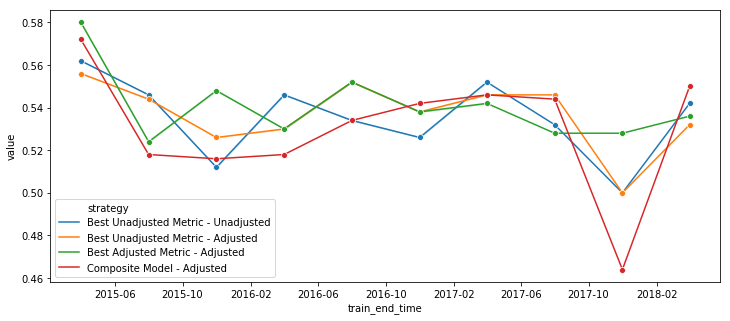

In [122]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

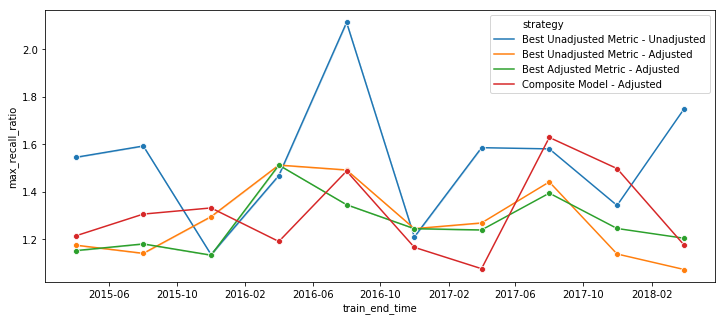

In [123]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)

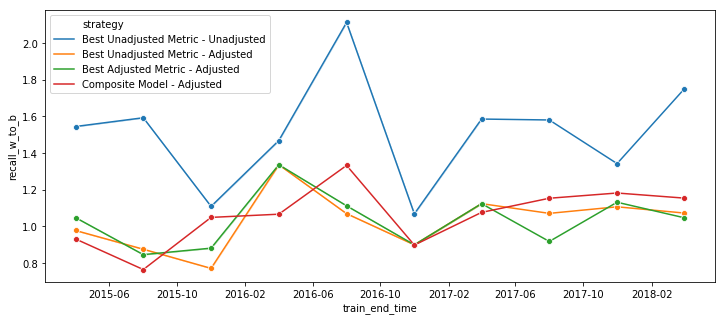

In [124]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

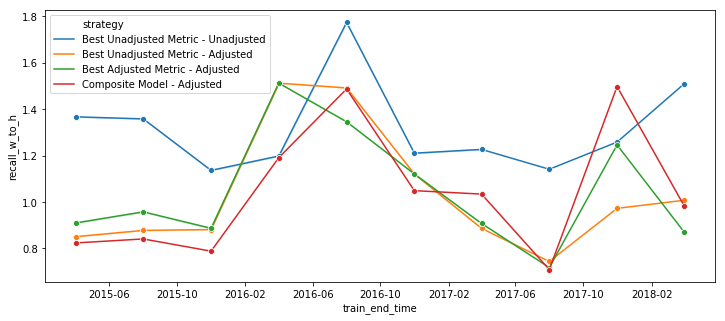

In [125]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

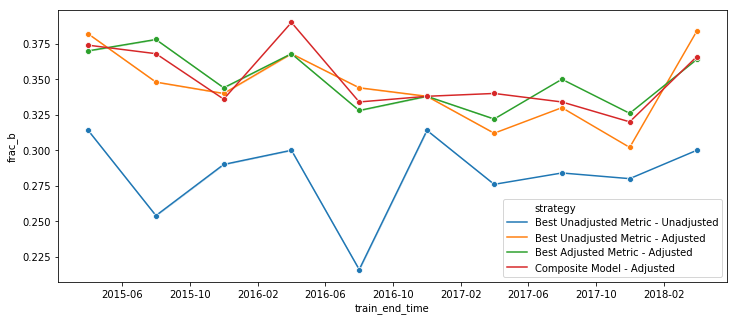

In [126]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='frac_b', hue='strategy', marker="o", ax=ax)

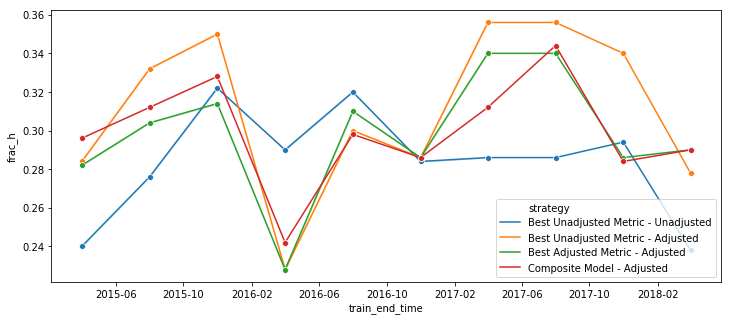

In [127]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='frac_h', hue='strategy', marker="o", ax=ax)

In [128]:
# load from scripted experiment...

with open('boostrap_hisp_frac_test.pkl', 'rb') as f:
    ts_df3 = pickle.load(f)

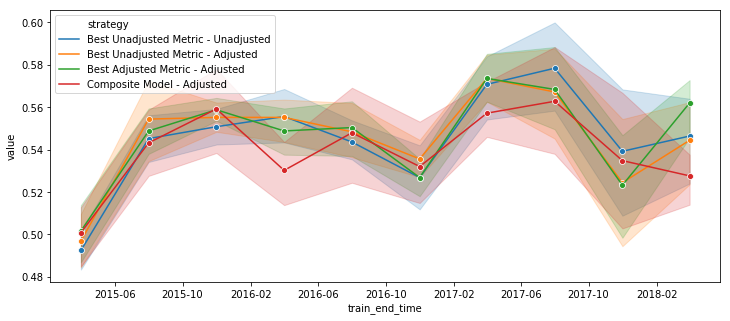

In [136]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['bootstrap_frac_h']==0.11) & (ts_df3['list_size']==500), ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

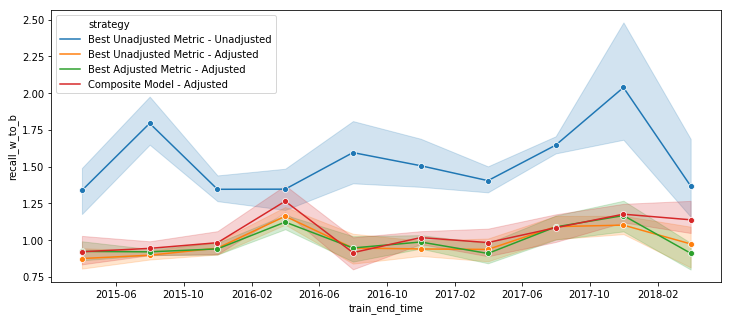

In [137]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['bootstrap_frac_h']==0.11) & (ts_df3['list_size']==500), ], x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

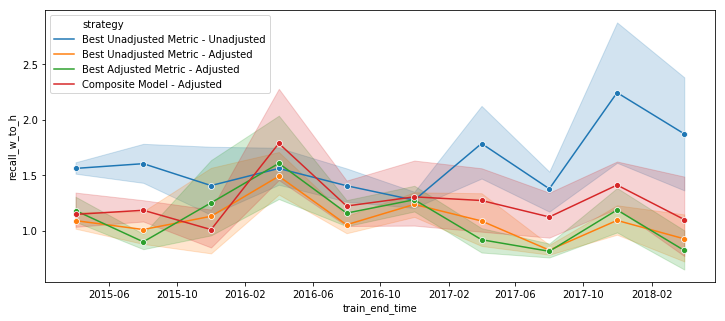

In [138]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['bootstrap_frac_h']==0.11) & (ts_df3['list_size']==500), ], x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

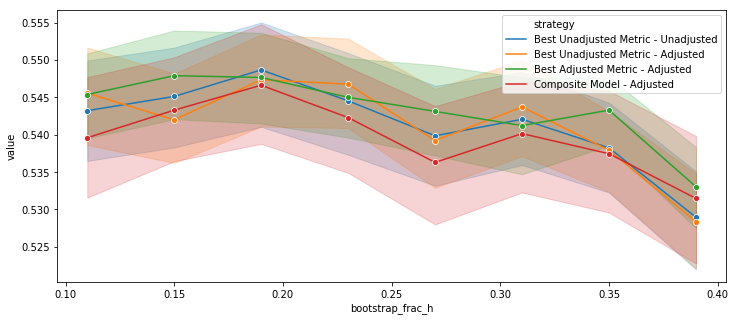

In [139]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==500, ], x='bootstrap_frac_h', y='value', hue='strategy', marker="o", ax=ax)

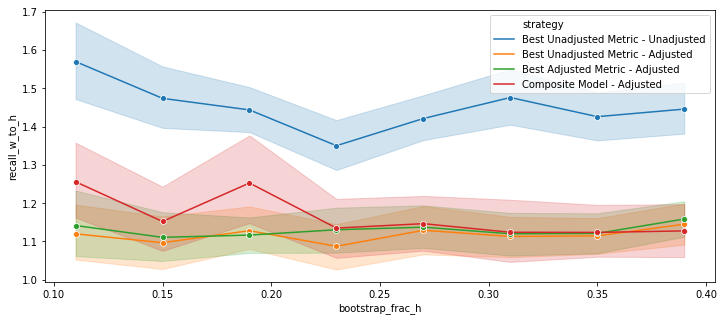

In [141]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==500, ], x='bootstrap_frac_h', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

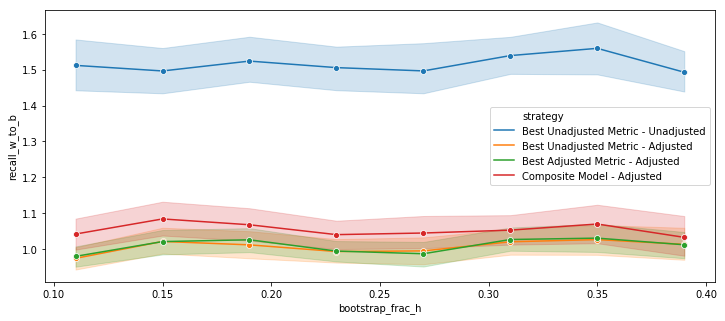

In [142]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==500, ], x='bootstrap_frac_h', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

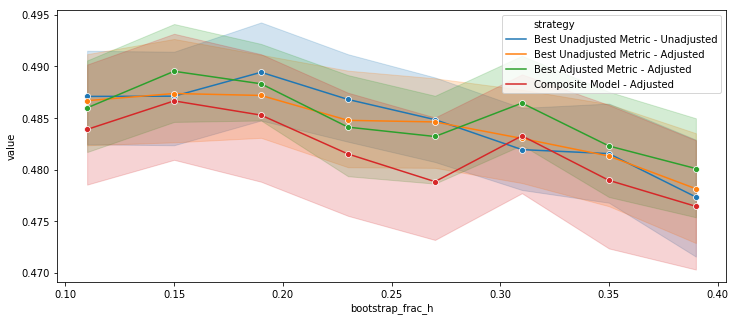

In [143]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==1000, ], x='bootstrap_frac_h', y='value', hue='strategy', marker="o", ax=ax)

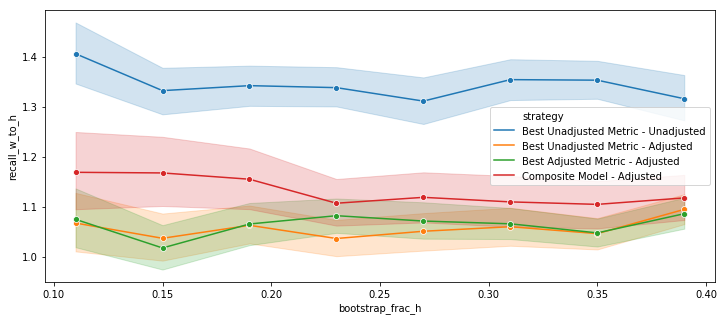

In [144]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==1000, ], x='bootstrap_frac_h', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

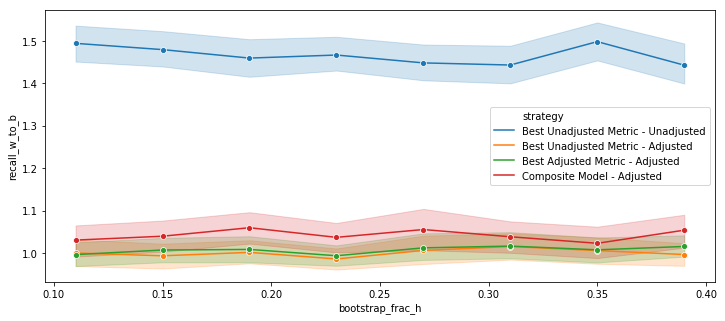

In [145]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==1000, ], x='bootstrap_frac_h', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

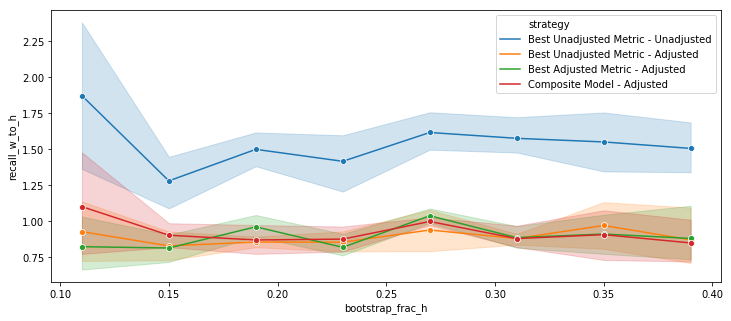

In [147]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['list_size']==500) & (ts_df3['train_end_time']=='2018-04-01'), ], x='bootstrap_frac_h', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

Probably a bit more to explore here, but the bootstrap approach actually does seem pretty helpful in telling a cleaner story here, whether looking at just one time point or aggregating across. Interestingly, when looking at a single time point, the variability doesn't seem to be clearly decreasing with the fraction of hispanics in the bootsrtap sample, but is much wider at the (current) value of 11%.

### Let's try adding in a smaller fraction...

In [150]:
# load from scripted experiment...

with open('boostrap_hisp_frac_test_new.pkl', 'rb') as f:
    ts_df3 = pickle.load(f)

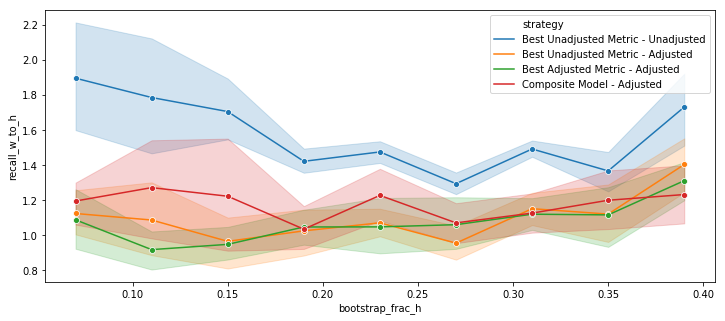

In [156]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['list_size']==500) & (ts_df3['train_end_time']=='2017-04-01'), ], x='bootstrap_frac_h', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)